# Customer Support Workflow with LangGraph

This notebook demonstrates a practical customer support workflow using LangGraph with two nodes:
1. Query Analyzer Node: Analyzes customer queries for sentiment and urgency
2. Response Generator Node: Generates appropriate responses based on the analysis

We'll use this to handle customer support queries in a more intelligent way by first understanding the context and then crafting appropriate responses.

# Install required packages if not already installed
%pip install python-dotenv langgraph>=0.6.4 langchain-openai>0.3.29

# Restart the kernel after installing packages


In [1]:
# Import required packages
from typing import Annotated, Sequence, Optional
from typing_extensions import TypedDict
from datetime import datetime
import os
from pathlib import Path

from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage

# Load environment variables
from dotenv import load_dotenv
load_dotenv()  # This will load your OPENAI_API_KEY from .env file

# Initialize the LLM with environment variables
llm = init_chat_model("openai:gpt-4.1-mini")


In [2]:
# Define our state type
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], "The messages in the conversation"]
    analysis: Annotated[dict, "Analysis of the customer query"]
    response_needed: Annotated[bool, "Whether the query requires a response"]
    filter_reason: Annotated[Optional[str], "Reason for not responding if response not needed"]

# Query Analyzer Node
def analyze_query(state: State) -> State:
    # Get the last message (customer query)
    last_message = state["messages"][-1]
    
    # Analyze the query using the LLM
    analysis_prompt = f"""
    Analyze the following customer support query for:
    1. Sentiment (positive, negative, neutral)
    2. Urgency (high, medium, low)
    3. Category (billing, technical, account, general)
    4. Key points (max 3)

    Query: {last_message.content}

    Provide the analysis in a JSON format with these exact keys:
    sentiment, urgency, category, key_points
    """
    
    analysis_response = llm.invoke(analysis_prompt)
    
    # Update state with analysis using json.loads instead of eval
    import json
    state["analysis"] = json.loads(analysis_response.content)  # Convert string to dict
    return state


In [3]:
# Filter Node
def filter_query(state: State) -> State:
    """
    Analyzes the query to determine if it requires a response.
    """
    last_message = state["messages"][-1]
    
    filter_prompt = f"""
    Analyze the following customer query and determine if it requires a response.
    Consider the following criteria:
    1. Is it a genuine question or request?
    2. Is it appropriate and business-related?
    3. Does it contain enough context to be actionable?
    4. Is it not spam or automated content?
    
    Query: {last_message.content}
    
    Respond in JSON format with these exact keys:
    - needs_response: boolean (true/false)
    - reason: string (explanation if no response needed)
    """
    
    filter_response = llm.invoke(filter_prompt)
    
    # Use json.loads instead of eval for safer JSON parsing
    import json
    filter_result = json.loads(filter_response.content)
    
    # Update state with filter decision
    state["response_needed"] = filter_result["needs_response"]
    state["filter_reason"] = filter_result.get("reason") if not filter_result["needs_response"] else None
    
    return state

# Define conditional routing
def should_respond(state: State) -> str:
    """
    Routes to either the response generator or end based on filter decision.
    """
    return "responder" if state["response_needed"] else END


In [4]:
# Response Generator Node
def generate_response(state: State) -> State:
    # Get the analysis and customer query
    analysis = state["analysis"]
    customer_query = state["messages"][-1].content
    
    # Create a prompt that uses the analysis to generate an appropriate response
    response_prompt = f"""
    You are a customer support agent. Generate a response to the customer query below.
    Use the provided analysis to tailor your response appropriately.

    Customer Query: {customer_query}

    Analysis:
    - Sentiment: {analysis['sentiment']}
    - Urgency: {analysis['urgency']}
    - Category: {analysis['category']}
    - Key Points: {', '.join(analysis['key_points'])}

    Guidelines:
    - For high urgency, express immediate attention
    - For negative sentiment, show extra empathy
    - For technical issues, be clear and step-by-step
    - For billing issues, be precise about numbers/dates
    - Keep the tone professional but friendly
    - Be concise but thorough

    Generate the response:
    """
    
    response = llm.invoke(response_prompt)
    
    # Add the response to the messages
    state["messages"].append(response)
    return state


In [5]:
# Create the workflow graph
graph = (
    StateGraph(State)
    .add_node("analyzer", analyze_query)
    .add_node("filter", filter_query)
    .add_node("responder", generate_response)
    .set_entry_point("analyzer")
    .add_edge("analyzer", "filter")
    .add_conditional_edges(
        "filter",
        should_respond,
        {
            "responder": "responder",
            END: END
        }
    )
    .add_edge("responder", END)
    .compile()
)

def process_customer_query(query: str) -> State:
    """
    Process a customer query through our workflow
    """
    # Initialize the state with the customer's message
    initial_state = State(
        messages=[HumanMessage(content=query)],
        analysis={},
        response_needed=True,  # Default to True, will be updated by filter
        filter_reason=None
    )
    
    # Run the workflow
    result = graph.invoke(initial_state)
    return result


Mermaid Syntax:
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	analyzer(analyzer)
	filter(filter)
	responder(responder)
	__end__([<p>__end__</p>]):::last
	__start__ --> analyzer;
	analyzer --> filter;
	filter -.-> __end__;
	filter -.-> responder;
	responder --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc


Graph Visualization:


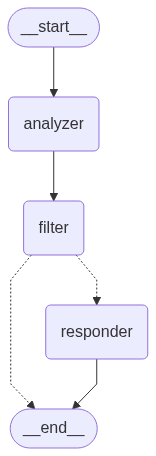

In [6]:
# Visualize the graph structure using LangGraph's built-in visualization
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

# Get the Mermaid syntax
print("Mermaid Syntax:")
print(graph.get_graph().draw_mermaid())

# Display the graph as PNG
print("\nGraph Visualization:")
display(Image(graph.get_graph().draw_mermaid_png(
    curve_style=CurveStyle.LINEAR,
    node_colors=NodeStyles(
        first="#90EE90",  # Light green for start
        last="#FFB6C1",   # Light pink for end
        default="#ADD8E6"  # Light blue for other nodes
    ),
    wrap_label_n_words=9,
    background_color="white",
    padding=10
)))

In [7]:
# Example customer queries
test_queries = [
    "I've been charged twice for my subscription this month and need this fixed immediately!",
    "Could you help me understand how to export my data from the platform?",
    "Just wanted to say thank you for the excellent service last week!",
    "Buy cheap watches at www.spam.com!!!",  # Spam message
    "",  # Empty message
    "asdfghjkl"  # Random keystrokes
]

# Process each query and display results
for query in test_queries:
    print(f"\nCustomer Query: {query}")
    print("-" * 50)
    
    result = process_customer_query(query)
    
    print("\nQuery Analysis:")
    print(f"Sentiment: {result['analysis']['sentiment']}")
    print(f"Urgency: {result['analysis']['urgency']}")
    print(f"Category: {result['analysis']['category']}")
    print(f"Key Points: {', '.join(result['analysis']['key_points'])}")
    
    print("\nFilter Decision:")
    print(f"Response Needed: {result['response_needed']}")
    if not result['response_needed']:
        print(f"Filter Reason: {result['filter_reason']}")
    elif len(result['messages']) > 1:  # Check if we have a response
        print("\nGenerated Response:")
        print(result["messages"][-1].content)
    print("\n" + "="*80 + "\n")



Customer Query: I've been charged twice for my subscription this month and need this fixed immediately!
--------------------------------------------------


JSONDecodeError: Expecting value: line 1 column 1 (char 0)